In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import cloud_identification

In [3]:
ds = xr.open_dataset('rico_with_shear__extract.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:                             (xt: 260, yt: 200, zt: 160)
Coordinates:
  * zt                                  (zt) float32 -12.5 12.5 37.5 62.5 ...
  * xt                                  (xt) float64 -2.488e+03 -2.462e+03 ...
  * yt                                  (yt) float64 -2.488e+03 -2.462e+03 ...
    time                                datetime64[ns] ...
Data variables:
    cvrxp                               (yt, xt, zt) float32 ...
    rad_tracer_thermals.num_std_div2.0  (yt, xt, zt) int8 ...
    w                                   (yt, xt, zt) float32 ...

In [128]:
mask = ds['rad_tracer_thermals.num_std_div2.0']
labels = cloud_identification.number_objects(scalar_field=ds.cvrxp, mask=mask)
da_labels = xr.DataArray(labels, coords=mask.coords)

In [144]:
def ellipsoid_mask(ds, Xc, s):
    x, y, z = ds.xt, ds.yt, ds.zt
    
    m = (x-Xc[0])**2./s[0]**2. + (y-Xc[1])**2./s[1]**2. + (z-Xc[2])**2./s[2]**2. < 1.0
    
    return m.transpose('yt', 'xt', 'zt')

mask = ellipsoid_mask(ds, [0., 0., 400.], [800., 300., 100.])
print(mask.shape, ds.w.shape)
labels = cloud_identification.number_objects(scalar_field=ds.cvrxp, mask=mask)
da_labels = xr.DataArray(labels, coords=mask.coords)

((200, 260, 160), (200, 260, 160))


In [145]:
from skimage.color import label2rgb
colors = np.random.random((labels.max()+1, 3))

colors_arr = colors[labels]

def plot_labels_on_scalar(da_s, da_labels, ax=None, doflip=True):
    v = da_s.squeeze().copy()
    v -= v.min()
    v /= v.max()
    from PIL import Image
    im = Image.fromarray(v.values*255)
    im = np.array(im.convert('RGB'))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,12))
    
    label_rgb = label2rgb(da_labels.values, bg_label=0, image=im, colors=colors, alpha=0.4,)
    d1, d0 = da_s.dims
    
    if doflip:
        fn_flip = np.flipud
    else:
        fn_flip = lambda v: v
    
    ax.imshow(fn_flip(label_rgb), extent=[da_s[d0].min(), da_s[d0].max(), da_s[d1].min(), da_s[d1].max()])
    ax.set_xlabel(d0)
    ax.set_ylabel(d1)

In [149]:
da_s = ds.w

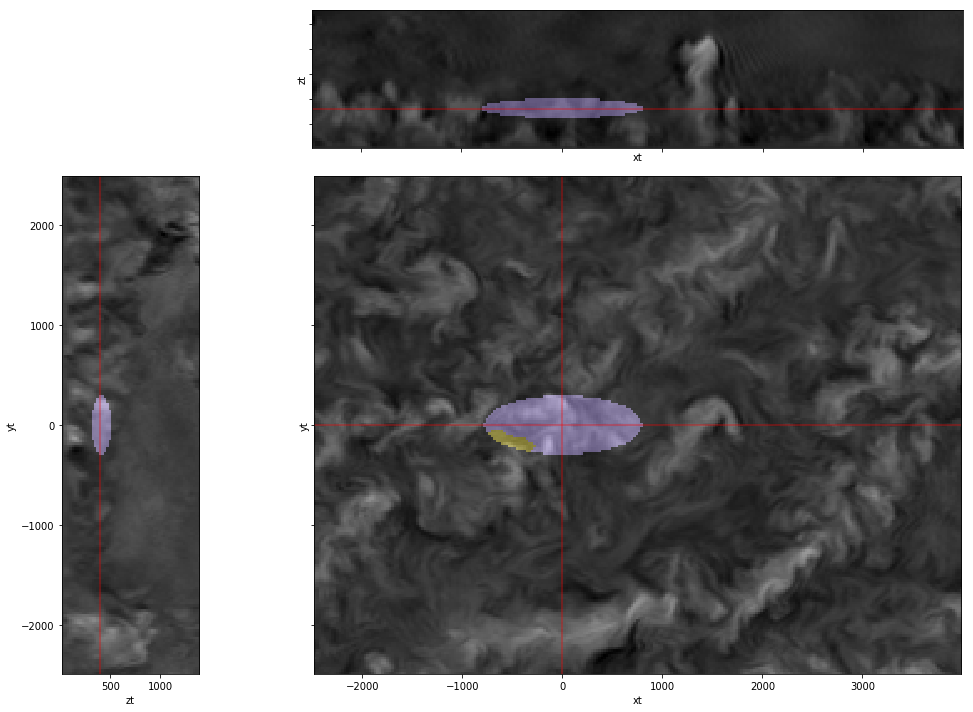

In [151]:

z = 400
z_max = 1400

r = 6

def p(x, z=400):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 10), sharey='row', sharex='col',
                             gridspec_kw=dict(width_ratios=[1,r], height_ratios=[1,r*0.6]))
    
    fn = lambda da: da.sel(zt=z, method='nearest').squeeze()
    ax = axes[1][1]
    plot_labels_on_scalar(fn(da_s), fn(da_labels), ax=ax)
    ax.axhline(x, color='red', alpha=0.4)
    ax.axvline(x, color='red', alpha=0.4)
    
    def fn_vert_crop(da, dim):
        other = dict(xt='yt', yt='xt')
        return (da
                .sel(zt=slice(0, z_max))
                .sel(**{ dim: x, 'method': 'nearest'})
                .squeeze()
                .transpose('zt', other[dim])
               )
    
    
    fn = lambda da: fn_vert_crop(da, 'yt')
    ax = axes[0][1]
    plot_labels_on_scalar(fn(da_s), fn(da_labels), ax=ax)
    ax.axhline(z, color='red', alpha=0.4)

    fn = lambda da: fn_vert_crop(da, 'xt').T
    ax = axes[1][0]
    plot_labels_on_scalar(fn(da_s), fn(da_labels), ax=ax, doflip=True)
    ax.axvline(z, color='red', alpha=0.4)
    
    axes[0][0].axis('off')
    
    plt.tight_layout()
    
p(x=0)

In [147]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [148]:
interact(p, x=(-1000, 1000, 25), z=(0, 1000, 50))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3gnLCBtYXg9MTAwMCwgbWluPS0xMDAwLCBzdGVwPTI1KSwgSW50U2xpZGVyKHZhbHVlPTQwMCzigKY=


<function __main__.p>